In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns 


In [2]:

df = pd.read_csv('ctcdata.csv')
df.describe()

,Redshift,Hubble parameter(km/s/Mpc),Error in Hubble Parameter(km/s/Mpc)
count,28.000000,28.000000,28.000000
mean,0.678429,106.978571,18.017857
std,0.558925,42.067559,13.356537
min,0.070000,68.600000,4.000000
25%,0.252500,76.825000,8.000000
50%,0.536500,91.000000,14.000000
75%,0.885000,119.000000,20.750000
max,2.300000,224.000000,62.000000


In [3]:
df.head()

,Redshift,Hubble parameter(km/s/Mpc),Error in Hubble Parameter(km/s/Mpc)
0,0.070,69.0,19.6
1,0.100,69.0,12.0
2,0.120,68.6,26.2
3,0.170,83.0,8.0
4,0.179,75.0,4.0


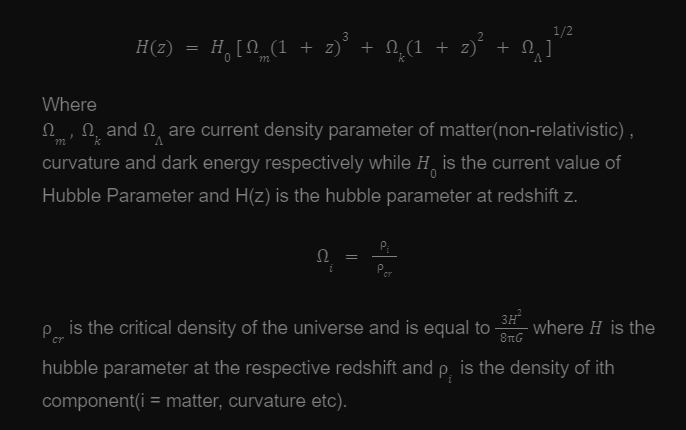

```H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5```  

H0 =  73.04 +/- 1.04 km s-1Mpc-1  
**Given a dataset for Hubble parameter at various redshifts, constrain and find the best fit values for Omega_m , Omega_k and plot 1 and 2D marginalized probability distributions for all three parameters and report uncertainty corresponding to 1,2 and 3**



In [4]:
h0 =  73.04; e0 = 1.04; h0u = h0 + e0; h0l = h0 - e0 

df.columns = ['z', 'hz', 'e']
df.head()

,z,hz,e
0,0.070,69.0,19.6
1,0.100,69.0,12.0
2,0.120,68.6,26.2
3,0.170,83.0,8.0
4,0.179,75.0,4.0


```Sqrt( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l```  
```Sqrt( H(z)/H0 ) = a*m + b*k + l```

In [5]:
df['a'] = (1+df['z'])**3
df['b'] = (1+df['z'])**2
df['hz-2'] = ((df['hz']-df['e'])/(h0+e0))**0.5
df['hz-1'] = ((df['hz']-df['e'])/(h0-e0))**0.5
df['hz0'] = ((df['hz']/h0))**0.5
df['hz1'] = ((df['hz']+df['e'])/(h0+e0))**0.5
df['hz2'] = ((df['hz']+df['e'])/(h0-e0))**0.5
df.head()

,z,hz,e,a,b,hz-2,hz-1,hz0,hz1,hz2
0,0.070,69.0,19.6,1.225043,1.144900,0.816607,0.828318,0.971951,1.093620,1.109304
1,0.100,69.0,12.0,1.331000,1.210000,0.877176,0.889757,0.971951,1.045664,1.060660
2,0.120,68.6,26.2,1.404928,1.254400,0.756541,0.767391,0.969129,1.131237,1.147461
3,0.170,83.0,8.0,1.601613,1.368900,1.006190,1.020621,1.066004,1.108333,1.124228
4,0.179,75.0,4.0,1.638858,1.390041,0.978991,0.993031,1.013328,1.032674,1.047484


In [7]:
# H(z) = H0 [ Omega_m*(1 + z)**3 + k*(1 + z)**2 + Omega_A ]**0.5
# H0 =  73.04 +/- 1.04 km s-1Mpc-1 

# Sqrt( H(z)/H0 ) = A*Omega_m + B*Omega_k + Omega_l  
# # Sqrt( H(z)/H0 ) = a*m + b*k + l

# hz-2 is the lower error bar
# hz+2 is the upper error bar
# hz0 is the central value
# a = (1+z)**3
# b = (1+z)**2
# l = Omega_l
# m = Omega_m
# k = Omega_k

# To find the best fit values of m, k, and l, we can use the least squares method.
from scipy.optimize import curve_fit

def model(z, m, k, l):
    return (m*(1+z)**3 + k*(1+z)**2 + l)

popt, pcov = curve_fit(model, df['z'], df['hz0'], sigma=df['e'], absolute_sigma=True)
print(popt)
print(np.sqrt(np.diag(pcov)))
print(f'value of m: {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'value of k: {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'value of l: {popt[2]} +/- {np.sqrt(pcov[2,2])}')




[-0.01898395  0.14773648  0.83143976]
[1.76918904 6.22256693 7.5218756 ]
value of m: -0.018983947201506972 +/- 1.7691890378313002
value of k: 0.1477364826583829 +/- 6.222566932576016
value of l: 0.8314397637604654 +/- 7.52187559788329


Best fit values of m, k, and l:[-0.03407945  0.19618831  0.79149276]
Loss = 0.002198552877136342
value of m: -0.03407945408106635
value of k: 0.1961883126621341
value of l: 0.7914927627718945


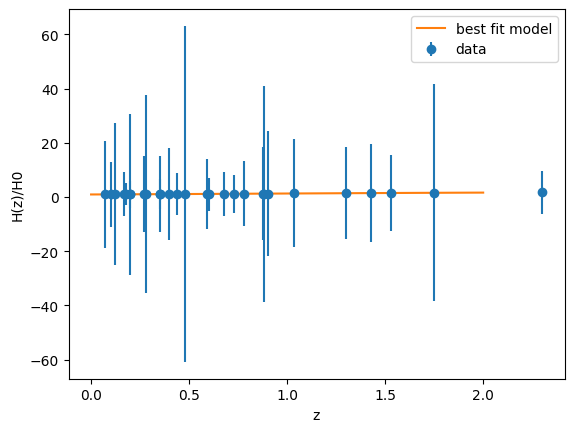

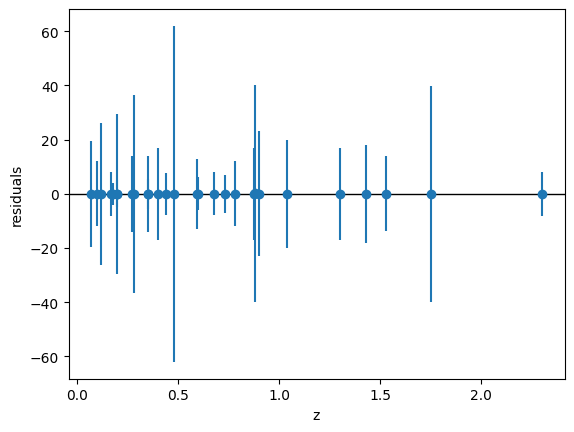

In [42]:
# To find the value by definig=ng a loss function and minimizing it
def loss(params):
    m, k, l = params
    # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
    # if value lies between the error bars, the loss is 0
    # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))

    for i in range(len(v)):
        if v[i] > df['hz2'][i]:
            loss[i] = (v[i] - df['hz2'][i])**2
        elif v[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - v[i])**2
        else:
            loss[i] = 0
    return np.sum(loss)
    
from scipy.optimize import minimize
def performance_of_loss(loss, popt):
    result = minimize(loss, popt)
    print(f'Best fit values of m, k, and l:{result.x}')
    print(f'Loss = {loss(result.x)}')

    # print the best fit values of m, k, and l
    print(f'value of m: {result.x[0]}')
    print(f'value of k: {result.x[1]}')
    print(f'value of l: {result.x[2]}')

    # plot the data and the best fit model
    plt.errorbar(df['z'], df['hz0'], yerr=df['e'], fmt='o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, *result.x), label='best fit model')
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()

    # plot the residuals
    plt.errorbar(df['z'], model(df['z'], *result.x) - df['hz0'], yerr=df['e'], fmt='o')
    plt.axhline(0, color='black', lw=1)
    plt.xlabel('z')
    plt.ylabel('residuals')
    plt.show()

performance_of_loss(loss, popt)

Best fit values of m, k, and l:[-0.03314021  0.19601599  0.78405705]
Loss = 0.008753732429435142
value of m: -0.03314021078911474
value of k: 0.19601599069514083
value of l: 0.7840570479915797


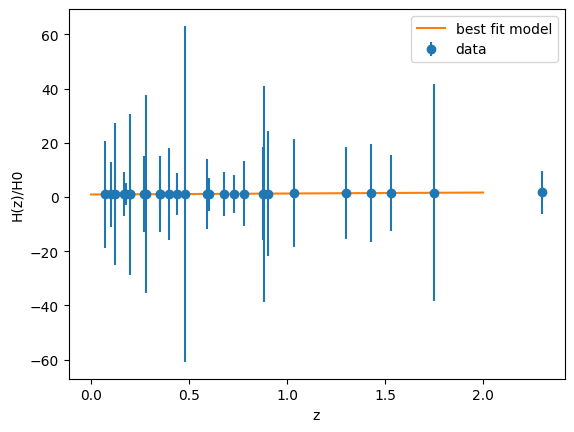

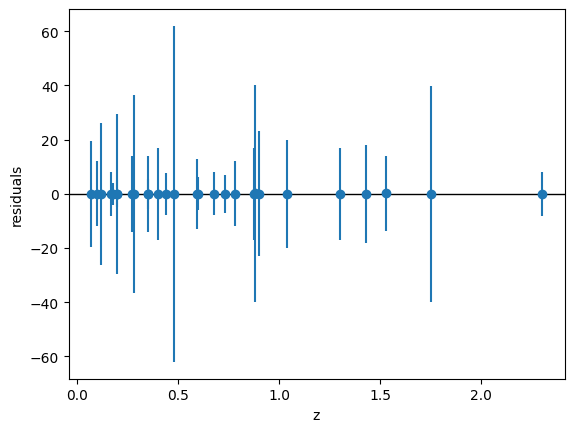

In [17]:
# To find the value by definig=ng a loss function and minimizing it
def loss(params):
    m, k, l = params
    # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
    # if value lies between the error bars, the loss is 0
    # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))

    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])**2
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])**2
        else:
            loss[i] = 0
    return np.sum(loss)
    
performance_of_loss(loss, popt)

Best fit values of m, k, and l:[-0.03237472  0.19732459  0.78440785]
Loss = 0.10621646284703957
value of m: -0.03237471892403603
value of k: 0.19732458800498118
value of l: 0.7844078462392411


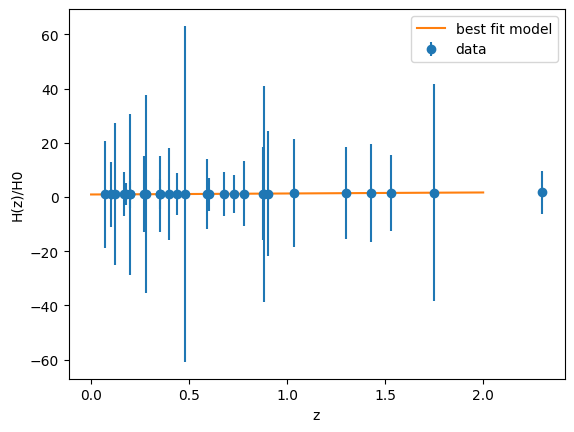

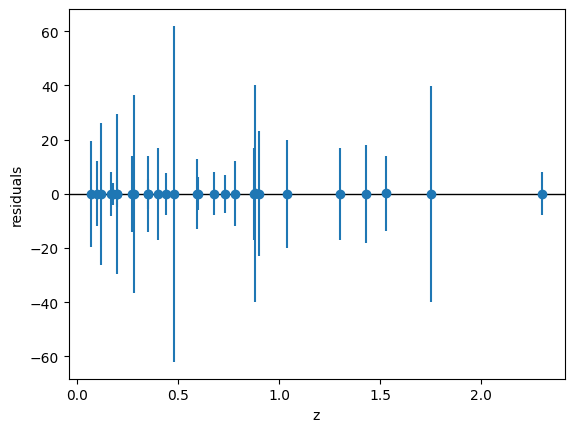

In [18]:
# To find the value by definig=ng a loss function and minimizing it
def loss(params):
    m, k, l = params
    # return np.sum(((model(df['z'], m, k, l) - df['hz0'])/df['e'])**2)
    # if value lies between the error bars, the loss is 0
    # if value is more than the upper error bar, the loss is (value - upper error bar), else (lower error bar - value)
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))

    for i in range(len(v)):
        loss[i] = (v[i] - df['hz0'][i])**2
    return np.sum(loss)
    
performance_of_loss(loss, popt)



Another methos from scratch

In [31]:
# Find the initial value of the parameters. Choose 3 rows from the data with minimum error and calculate the value of m, k, and l
df.sort_values(by='e').head(3) # 4,5, 9


,z,hz,e,a,b,hz-2,hz-1,hz0,hz1,hz2
4,0.179,75.0,4.0,1.638858,1.390041,0.978991,0.993031,1.013328,1.032674,1.047484
5,0.199,75.0,5.0,1.723684,1.437601,0.972072,0.986013,1.013328,1.039189,1.054093
9,0.350,76.3,5.6,2.460375,1.822500,0.976920,0.990931,1.022073,1.051457,1.066536


In [49]:

Y_matrix = np.array([df['hz0'].iloc[4], df['hz0'].iloc[5], df['hz0'].iloc[9]]).T
# Y = MX
M_matrix = np.array([   [df['a'].iloc[4], df['b'].iloc[4], 1], 
                        [df['a'].iloc[5], df['b'].iloc[5], 1], 
                        [df['a'].iloc[9], df['b'].iloc[9], 1]])

X = np.linalg.solve(M_matrix, Y_matrix)
print(X)

# X = np.matmul(np.linalg.inv(M_matrix), Y_matrix)
# # Calculate the error in the parameters
# Y_confirm = np.matmul(M_matrix, X)

# print(f'X_matrix: {X}')
# print(f'Y_matrix: {Y_matrix}')
# print(f'Y_confirm: {Y_confirm}')

# Now initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
def loss_0(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        loss[i] = (v[i] - df['hz0'][i])**2
    return np.sum(loss) 

def loss_1(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1'][i]:
            loss[i] = (v[i] - df['hz1'][i])**2
        elif v[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - v[i])**2
        else:
            loss[i] = 0
    return np.sum(loss)

def loss_2(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz2'][i]:
            loss[i] = (v[i] - df['hz2'][i])**2
        elif v[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - v[i])**2
        else:
            loss[i] = 0
    return np.sum(loss)

from scipy.optimize import minimize

result_0 = minimize(loss_0, X)
# Report the variance of the parameters
print(f'0) Best fit values of m, k, and l:{result_0.x}')
print(f'Loss_0 = {loss_0(result_0.x)}')
print(f'Loss_1 = {loss_1(result_0.x)}')
print(f'Loss_2 = {loss_2(result_0.x)}')
# Variance of the parameters
print(f'Variance of m: {result_0.hess_inv[0,0]}, Variance of k = {result_0.hess_inv[1,1]}, Variance of l = {result_0.hess_inv[2,2]}')

result_1 = minimize(loss_1, X)
print(f'1) Best fit values of m, k, and l:{result_1.x}')
print(f'Loss_0 = {loss_0(result_1.x)}')
print(f'Loss_1 = {loss_1(result_1.x)}')
print(f'Loss_2 = {loss_2(result_1.x)}')
print(f'Variance of m: {result_1.hess_inv[0,0]}, Variance of k = {result_1.hess_inv[1,1]}, Variance of l = {result_1.hess_inv[2,2]}')
result_2 = minimize(loss_2, X)
print(f'2) Best fit values of m, k, and l:{result_2.x}')
print(f'Loss_0 = {loss_0(result_2.x)}')
print(f'Loss_1 = {loss_1(result_2.x)}')
print(f'Loss_2 = {loss_2(result_2.x)}')
print(f'Variance of m: {result_2.hess_inv[0,0]}, Variance of k = {result_2.hess_inv[1,1]}, Variance of l = {result_2.hess_inv[2,2]}')


# Tabulate the results using dataframes
df_results = pd.DataFrame([result_0.x, result_1.x, result_2.x], columns=['m', 'k', 'l'], index=['loss_0', 'loss_1', 'loss_2'])
df_results['loss'] = [loss_0(result_0.x), loss_1(result_1.x), loss_2(result_2.x)]
df_results


[ 0.17416501 -0.31063062  1.159686  ]
0) Best fit values of m, k, and l:[-0.03237432  0.19732325  0.78440948]
Loss_0 = 0.10621646284438574
Loss_1 = 0.010541111552726256
Loss_2 = 0.004238578933461479
Variance of m: 0.03125954041094462, Variance of k = 0.3646565130254531, Variance of l = 0.627971019861611
1) Best fit values of m, k, and l:[-0.03314021  0.19601598  0.78405707]
Loss_0 = 0.11075052535315612
Loss_1 = 0.008753732429400099
Loss_2 = 0.002534574714538446
Variance of m: 0.027144069065458073, Variance of k = 0.35265504384969965, Variance of l = 0.9277282981412458
2) Best fit values of m, k, and l:[-0.03407946  0.19618832  0.79149283]
Loss_0 = 0.11427587410607962
Loss_1 = 0.009535846202271343
Loss_2 = 0.0021985528771992623
Variance of m: 0.03043637174167268, Variance of k = 0.4075444006540175, Variance of l = 1.2266181713438595


,m,k,l,loss
loss_0,-0.032374,0.197323,0.784409,0.106216
loss_1,-0.033140,0.196016,0.784057,0.008754
loss_2,-0.034079,0.196188,0.791493,0.002199


In [43]:
# Add a column of hz1.5 = (hz1+hz2)/2 and hz-1.5 = (hz-1+hz-2)/2
df['hz1.5'] = (df['hz1'] + df['hz2'])/2
df['hz-1.5'] = (df['hz-1'] + df['hz-2'])/2

def loss_1_5(params):
    m, k, l = params
    v = model(df['z'], m, k, l)
    loss = np.zeros(len(v))
    # print(f'len(v): {len(v)}')
    for i in range(len(v)):
        if v[i] > df['hz1.5'][i]:
            loss[i] = (v[i] - df['hz1.5'][i])**2
        elif v[i] < df['hz-1.5'][i]:
            loss[i] = (df['hz-1.5'][i] - v[i])**2
        else:
            loss[i] = 0
    return np.sum(loss)

result_1_5 = minimize(loss_1_5, X)
df_results.loc['loss_1.5'] = [result_1_5.x[0], result_1_5.x[1], result_1_5.x[2], loss_1_5(result_1_5.x)]
df_results



,m,k,l,loss
loss_0,-0.032374,0.197323,0.784409,0.106216
loss_1,-0.033140,0.196016,0.784057,0.008754
loss_2,-0.034079,0.196188,0.791493,0.002199
loss_1.5,-0.033575,0.195939,0.788261,0.004798


For loss_0


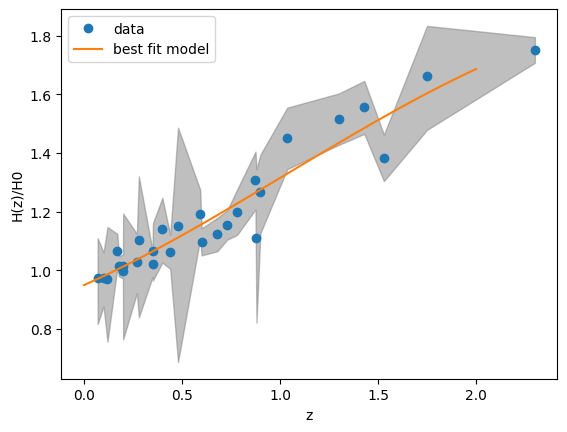

For loss_1


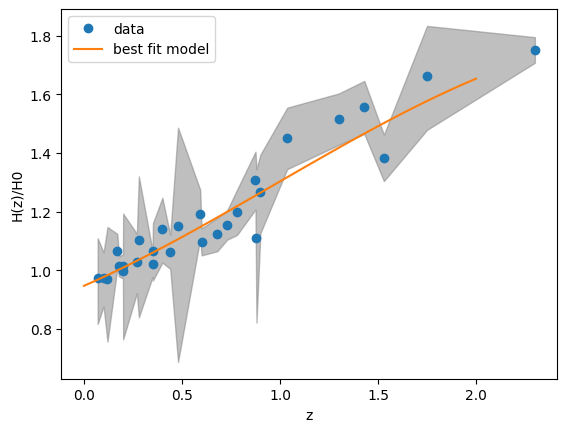

For loss_2


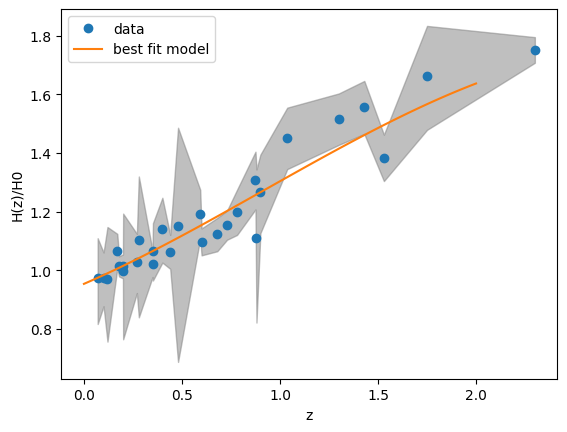

For loss_1.5


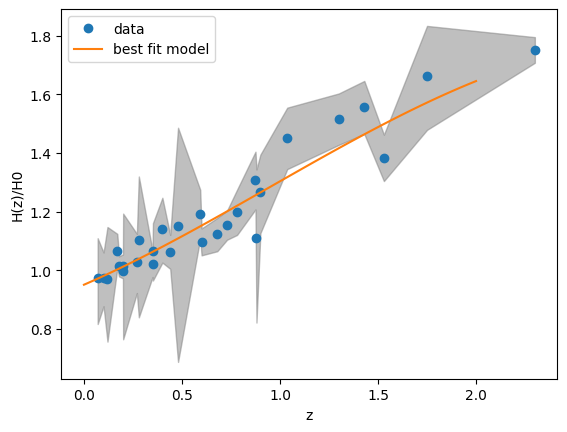

In [62]:
# # Plot the tolerance bands
# plt.plot(df['z'], df['hz0'], 'o', label='data')
# z = np.linspace(0, 2, 100)
# plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
# plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='gray', alpha=0.5)
# plt.xlabel('z')
# plt.ylabel('H(z)/H0')
# plt.legend()
# plt.show()

def plot_tolerances(m, k, l):
    plt.plot(df['z'], df['hz0'], 'o', label='data')
    z = np.linspace(0, 2, 100)
    plt.plot(z, model(z, m, k, l), label='best fit model')
    plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='gray', alpha=0.5)
    plt.xlabel('z')
    plt.ylabel('H(z)/H0')
    plt.legend()
    plt.show()

print('For loss_0')
plot_tolerances(result_0.x[0], result_0.x[1], result_0.x[2])
print('For loss_1')
plot_tolerances(result_1.x[0], result_1.x[1], result_1.x[2])
print('For loss_2')
plot_tolerances(result_2.x[0], result_2.x[1], result_2.x[2])
print('For loss_1.5')
plot_tolerances(result_1_5.x[0], result_1_5.x[1], result_1_5.x[2])


In [52]:
# Initialize the parameters with the values of m, k, and l, define loss function and use gradient descent to minimize the loss function
import torch
import torch.optim as optim
import torch.nn as nn

# Convert the data to tensors
z = torch.tensor(df['z'].values, dtype=torch.float32)
hz0 = torch.tensor(df['hz0'].values, dtype=torch.float32)
e = torch.tensor(df['e'].values, dtype=torch.float32)
# [ 0.17416501 -0.31063062  1.159686  ] initial values of m, k, and l

# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.m = nn.Parameter(torch.tensor(0.17416501, requires_grad=True))
        self.k = nn.Parameter(torch.tensor(-0.31063062, requires_grad=True))
        self.l = nn.Parameter(torch.tensor(1.159686, requires_grad=True))

        
    def forward(self, z):
        return (self.m*(1+z)**3 + self.k*(1+z)**2 + self.l)
    
model_0, model_1, model_2 = Model(), Model(), Model()

# Define the loss function
def loss_fn_0(y, y_pred, e):
    return torch.sum((y - y_pred)**2/e**2)

def loss_fn_1(y, y_pred, e):
    loss = torch.zeros(len(y))
    for i in range(len(y)):
        if y_pred[i] > df['hz1'][i]:
            loss[i] = (y_pred[i] - df['hz1'][i])**2
        elif y_pred[i] < df['hz-1'][i]:
            loss[i] = (df['hz-1'][i] - y_pred[i])**2
        else:
            loss[i] = 0
    return torch.sum(loss)

def loss_fn_2(y, y_pred, e):
    loss = torch.zeros(len(y))
    for i in range(len(y)):
        if y_pred[i] > df['hz2'][i]:
            loss[i] = (y_pred[i] - df['hz2'][i])**2
        elif y_pred[i] < df['hz-2'][i]:
            loss[i] = (df['hz-2'][i] - y_pred[i])**2
        else:
            loss[i] = 0
    return torch.sum(loss)

# Define the optimizer
optimizer = optim.Adam([model_0.m, model_0.k, model_0.l], lr=0.01)


# Train the model
def train(model, z, hz0, e, loss_fn, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(z)
        loss = loss_fn(hz0, y_pred, e)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print('Epoch:', epoch, 'Loss:', loss.item())
    return model

model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=1000)
model_1 = train(model_1, z, hz0, e, loss_fn_1, optimizer, epochs=1000)
model_2 = train(model_2, z, hz0, e, loss_fn_2, optimizer, epochs=1000)

# Report the best fit values of m, k, and l
print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')
print(f'For loss_1: m = {model_1.m.item()}, k = {model_1.k.item()}, l = {model_1.l.item()}')
print(f'For loss_2: m = {model_2.m.item()}, k = {model_2.k.item()}, l = {model_2.l.item()}')



Epoch: 0 Loss: 0.08440517634153366
Epoch: 100 Loss: 0.004478662274777889
Epoch: 200 Loss: 0.002905774861574173
Epoch: 300 Loss: 0.001723896712064743
Epoch: 400 Loss: 0.0010282928124070168
Epoch: 500 Loss: 0.0006881602457724512
Epoch: 600 Loss: 0.000546725932508707
Epoch: 700 Loss: 0.0004961818922311068
Epoch: 800 Loss: 0.0004805869539268315
Epoch: 900 Loss: 0.00047642807476222515
Epoch: 0 Loss: 5.876148223876953
Epoch: 100 Loss: 5.876148223876953
Epoch: 200 Loss: 5.876148223876953
Epoch: 300 Loss: 5.876148223876953
Epoch: 400 Loss: 5.876148223876953
Epoch: 500 Loss: 5.876148223876953
Epoch: 600 Loss: 5.876148223876953
Epoch: 700 Loss: 5.876148223876953
Epoch: 800 Loss: 5.876148223876953
Epoch: 900 Loss: 5.876148223876953
Epoch: 0 Loss: 5.694817066192627
Epoch: 100 Loss: 5.694817066192627
Epoch: 200 Loss: 5.694817066192627
Epoch: 300 Loss: 5.694817066192627
Epoch: 400 Loss: 5.694817066192627
Epoch: 500 Loss: 5.694817066192627
Epoch: 600 Loss: 5.694817066192627
Epoch: 700 Loss: 5.6948170

In [55]:
model_0 = train(model_0, z, hz0, e, loss_fn_0, optimizer, epochs=2000)
print(f'For loss_0: m = {model_0.m.item()}, k = {model_0.k.item()}, l = {model_0.l.item()}')


Epoch: 0 Loss: 0.0004752431414090097
Epoch: 100 Loss: 0.0004752429958898574
Epoch: 200 Loss: 0.000475242588436231
Epoch: 300 Loss: 0.00047524296678602695
Epoch: 400 Loss: 0.0004752427339553833
Epoch: 500 Loss: 0.000475243286928162
Epoch: 600 Loss: 0.00047524285037070513
Epoch: 700 Loss: 0.00047524285037070513
Epoch: 800 Loss: 0.0004752427921630442
Epoch: 900 Loss: 0.00047524285037070513
Epoch: 1000 Loss: 0.00047524282126687467
Epoch: 1100 Loss: 0.00047524282126687467
Epoch: 1200 Loss: 0.00047524282126687467
Epoch: 1300 Loss: 0.00047524282126687467
Epoch: 1400 Loss: 0.00047524282126687467
Epoch: 1500 Loss: 0.0006855682586319745
Epoch: 1600 Loss: 0.00047529765288345516
Epoch: 1700 Loss: 0.0004752432578243315
Epoch: 1800 Loss: 0.00047524302499368787
Epoch: 1900 Loss: 0.0004752430832013488
For loss_0: m = -0.018983950838446617, k = 0.14773648977279663, l = 0.8314396739006042


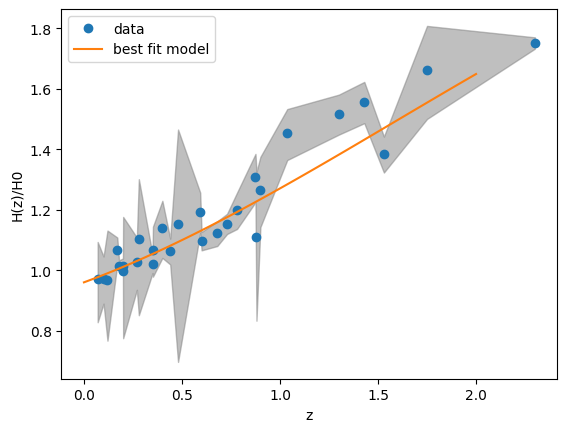

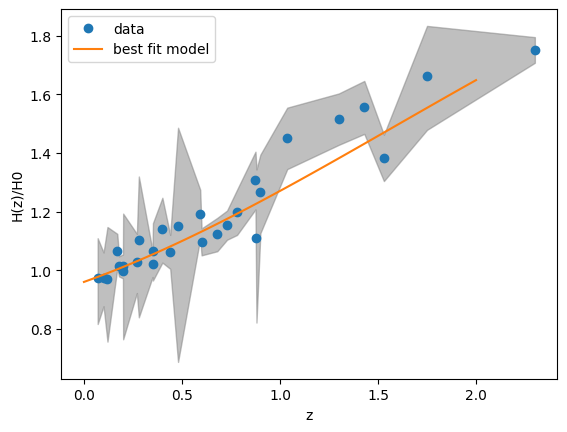

In [61]:
# For loss_0: m = -0.018983950838446617, k = 0.14773648977279663, l = 0.8314396739006042
# m_final = model_0.m.item(); k_final = model_0.k.item(); l_final = model_0.l.item()
m_final, k_final, l_final = -0.018983950838446617, 0.14773648977279663, 0.8314396739006042  

# Plot the data 
plt.plot(df['z'], df['hz0'], 'o', label='data')
z = np.linspace(0, 2, 100)
plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
plt.fill_between(df['z'], df['hz-1'], df['hz1'], color='gray', alpha=0.5)
plt.xlabel('z')
plt.ylabel('H(z)/H0')
plt.legend()
plt.show()

# Plot the tolerance bands
plt.plot(df['z'], df['hz0'], 'o', label='data')
z = np.linspace(0, 2, 100)
plt.plot(z, model(z, m_final, k_final, l_final), label='best fit model')
plt.fill_between(df['z'], df['hz-2'], df['hz2'], color='gray', alpha=0.5)
plt.xlabel('z')
plt.ylabel('H(z)/H0')
plt.legend()
plt.show()
